In [1]:
# stanのバージョンが v3.3 になり import pystan ではなくではなく import stan とライブラリ名がが
# 変わると当時に、build 時に以下のエラーがでるようになった。
# 対策としてnest_asyncio というライブラリを使う必要があるため、最初の一回のみライブラリをインストールしておくしておく
# 一回 install すれば、あとはこのコマンドは不要なので、先頭にに#をつけてコメントにしておいてください。
## RuntimeError: asyncio.run() cannot be called from a running event loop

!pip install nest_asyncio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

input_dir = "/content/drive/MyDrive/input/"
output_dir = "/content/drive/MyDrive/output/"

# pystan と、パラメータの事後分布の推定結果を可視化するためのライブラリとして arviz を利用する。
import stan
import arviz
import nest_asyncio # stanのバージョンアップ対策
nest_asyncio.apply() # stanのバージョンアップ対策

Mounted at /content/drive


## 2次元の混合ガウス分布のStanを用いた推定

note13-1をD次元の多変量正規分布に拡張したモデルを使って、、note12-1のデータの予測を試みます。

In [3]:
# GMMのギブスサンプリング版でライブラリ
from scipy.stats import multivariate_normal # 多次元ガウス分布

In [4]:
# note12-1で保存したパラメータを利用する
import json
with open(output_dir + 'note12-1_output.json') as json_file:
   json_data = json.load(json_file) # JSONファイルを辞書型の変数として読み出す

#print (json_data)

# 個別の変数に戻す
D = json_data['D'] # 次元数:(固定)
K = json_data['K'] # クラスタ数
N = json_data['N']

# ndarray 型に戻し、行列などに reshape で戻す
# 真のモデル関連
mu_truth_kd = np.array(json_data['mu_truth_kd']) # K個の真の平均を指定
sigma2_truth_kdd = np.array(json_data['sigma2_truth_kdd']).reshape(K,D,D) # K個の真の共分散行列を指定
pi_truth_k = np.array(json_data['pi_truth_k']) # 真の混合比率を指定（各値は0以上で、合計は1になること）
# 真のモデルから生成した観測データ関連
s_truth_nk = np.array(json_data['s_truth_nk']).reshape(N,K) # 潜在変数
s_truth_n = np.array(json_data['s_truth_n']).reshape(N,) # クラスタ番号
x_nd = np.array(json_data['x_nd']).reshape(N,D) # ランダムサンプリングより得た観測データ

# 作図データを作成作成
# 作図用のx軸のxの値を作成 (K個のクラスタそれぞれで平均値±3標準偏差を計算して、その最小値から最大値までを範囲とする)
x_1_line = np.linspace(
    np.min(mu_truth_kd[:, 0] - 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])), 
    np.max(mu_truth_kd[:, 0] + 3 * np.sqrt(sigma2_truth_kdd[:, 0, 0])), 
    num=300
)

# 作図用のy軸のxの値を作成 (K個のクラスタそれぞれで平均値±3標準偏差を計算して、その最小値から最大値までを範囲とする)
x_2_line = np.linspace(
    np.min(mu_truth_kd[:, 1] - 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])), 
    np.max(mu_truth_kd[:, 1] + 3 * np.sqrt(sigma2_truth_kdd[:, 1, 1])), 
    num=300
)

# 確率密度を等高線図にする際に格子状の点(2軸の全ての値が直交する点)を渡す必要があるため、作図用の格子状の点を作成する。する。
# x_1_lineとx_2_lineの要素の全ての組み合わせを持つような2次元配列に変換している。
x_1_grid, x_2_grid = np.meshgrid(x_1_line, x_2_line)

# x_1_grid, x_2_gridの要素を列として持つ2次元配列を作成をし、作図用のxの点とする。
x_point = np.stack([x_1_grid.flatten(), x_2_grid.flatten()], axis=1)

# 作図用に各次元の要素数を保存：
# 計算結果の確率密度は1次元配列になり、作図時にx_1_grid, x_2_gridと同じ形状にする必要があるため、形状をx_dimとして保存
x_dim = x_1_grid.shape

# 観測モデルの確率密度を計算しなおしておく
# K個のパラメータmu_truth_kd, sigmga2_truth_ddkを使って、x_point_matの点ごとに、次の混合ガウス分布の式で確率密度を計算
true_model = 0
for k in range(K):
    # クラスタkの分布の確率密度を計算
    tmp_density = multivariate_normal.pdf(x=x_point, mean=mu_truth_kd[k], cov=sigma2_truth_kdd[k])
    
    # K個の分布の加重平均を計算
    true_model += pi_truth_k[k] * tmp_density

# 確認
print ("pi", pi_truth_k) 
print ("mu", mu_truth_kd)
print ("sigma", sigma2_truth_kdd)


pi [0.45 0.25 0.3 ]
mu [[  5.  35.]
 [-20. -10.]
 [ 30. -20.]]
sigma [[[250.  65.]
  [ 65. 270.]]

 [[125. -45.]
  [-45. 175.]]

 [[210. -15.]
  [-15. 250.]]]


In [5]:
x_nd[:5]

array([[ 15.26981593,   0.50211785],
       [-19.85544849,  14.49733537],
       [  0.69618467,  35.21460929],
       [-17.27956284,  47.20607157],
       [ -3.11393543,  40.78695067]])

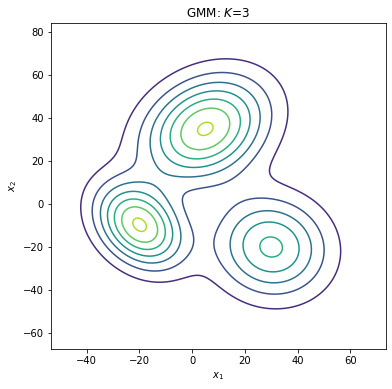

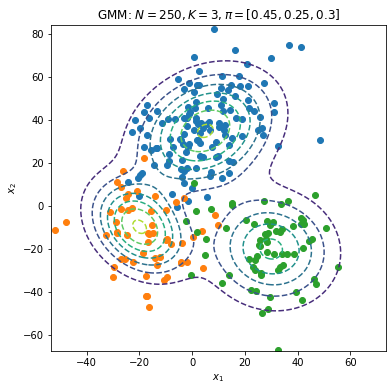

In [6]:
# 観測モデルを作図
plt.figure(figsize=(6, 6))
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim)) # 真の分布
plt.title('GMM: $K$=' + str(K))
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

# モデルに観測データの散布図を重ねて表示
plt.figure(figsize=(6, 6))
for k in range(K):
    k_idx, = np.where(s_truth_n == k) # クラスタkのデータのインデック
    plt.scatter(x=x_nd[k_idx, 0], y=x_nd[k_idx, 1], label='cluster:' + str(k + 1)) # 観測データ
plt.contour(x_1_grid, x_2_grid, true_model.reshape(x_dim), linestyles='--') # 真の分布
plt.title('GMM: $N=' + str(N) + ', K=' + str(K) + 
          ', \pi=[' + ', '.join([str(pi) for pi in pi_truth_k]) + ']$')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [7]:
stan_data = dict(x=x_nd, D=D, N=N, K=K)

In [8]:
from sklearn.datasets import make_classification

NUM_MIXTURE_COMPONENTS = 3
NUM_DIMENSIONS = 2

def create_data(num_samples):
    # 乱数で混合重みを生成
    weights = np.random.random(NUM_MIXTURE_COMPONENTS)
    weights = (weights / weights.sum()).tolist()

    feature_vectors, labels = make_classification(
        n_samples=num_samples, n_features=NUM_DIMENSIONS, n_informative=NUM_DIMENSIONS, n_redundant=0,
        n_classes=NUM_MIXTURE_COMPONENTS, n_clusters_per_class=1, weights=weights)

    # グラフ描画用
    plt.scatter(feature_vectors[:, 0], feature_vectors[:, 1], marker='o')
    plt.show()

    return feature_vectors

In [9]:
# 弱情報事前分布を設定しないver.
stan_code1 = """
data {
  int<lower=1> D; // 多次元正規分布の次元
  int<lower=1> N; // サンプルサイズ
  int<lower=1> K; // 混合数
  vector[D] x[N]; // データ
}

parameters {
  simplex[K] pi;   // 混合比率
  vector[D] mu[K]; // 平均 (2次元ででorderedを設定するわけにはいかない)
  vector<lower=0.0>[D] sigma[K]; // 分散共分散行列 cov_matrix<lower=0.0>[D] sigma[K] でもOKか。
}

model {
  vector[K] log_pi = log(pi);

  for(i in 1:N){
    vector[K] logp = log_pi;
    for(k in 1:K){
      logp[k] += normal_lpdf(x[i] | mu[k], sigma[k]);
    }
    target += log_sum_exp(logp);
  }
}
"""

# 弱情報事前分布を設定したしたver.
stan_code2 = """
data {
  int<lower=1> D; // 多次元正規分布の次元
  int<lower=1> N; // サンプルサイズ
  int<lower=1> K; // 混合数
  vector[D] x[N]; // データ
}

parameters {
  simplex[K] pi;   // 混合比率
  vector[D] mu[K]; // 平均
  vector<lower=0.0>[D] sigma[K]; // 分散共分散行列
}

model {
  vector[K] log_pi = log(pi);

  for (k in 1:K) { //
    mu[k] ~ normal(0,10);
    sigma[k] ~ cauchy(0,10);
  }

  for(i in 1:N){
    vector[K] logp = log_pi;
    for(k in 1:K){
      logp[k] += normal_lpdf(x[i] | mu[k], sigma[k]);
    }
    target += log_sum_exp(logp);
  }
}
"""

In [10]:
model1 = stan.build(stan_code1, data=stan_data, random_seed=1)
# MCMCの実行
fit1 = model1.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

# WARNINGがでる

Building...



Building: 52.8s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  13% (1501/12000)
Sampling:  13% (1601/12000)
Sampling:  14% (1701/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2201/12000)
Sampling:  19% (2301/12000)
Sampling:  20% (2401/12000)
Sampling:  21% (2501/12000)
Sampling:  22% (2600/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Samp

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:713: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_edges[:-1]) / 2
/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.7/dist-packages/arviz/stats/density_utils.py:713: RuntimeWarning: overflow encountered in add
  grid = (grid_edges[1:] + grid_edges[:-1]) / 2
/usr/local/lib/python3.7/dist-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python3.7/dist-pack

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.251,0.428,0.000,0.996,0.214,0.164,7.0,36.0,1.66
pi[1],0.499,0.494,0.000,0.998,0.247,0.189,6.0,94.0,1.75
pi[2],0.250,0.427,0.000,0.996,0.213,0.163,7.0,47.0,1.57
"mu[0, 0]",77.855,70.637,3.088,221.658,33.884,25.782,4.0,11.0,3.17
"mu[0, 1]",4.831,20.878,-32.659,37.043,9.966,7.577,5.0,14.0,2.58
"mu[1, 0]",16.772,35.378,-30.882,80.782,17.411,13.304,5.0,14.0,2.57
"mu[1, 1]",-25.234,44.413,-92.901,14.440,21.422,16.314,6.0,19.0,2.04
"mu[2, 0]",-18.804,51.375,-147.176,29.287,18.166,13.366,8.0,12.0,2.08
"mu[2, 1]",54.379,61.132,-61.409,189.030,18.981,13.819,9.0,14.0,1.71
"sigma[0, 0]",inf,inf,18.356,inf,NaN,NaN,8.0,39.0,1.54


/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:2450: RuntimeWarning: overflow encountered in double_scalars
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


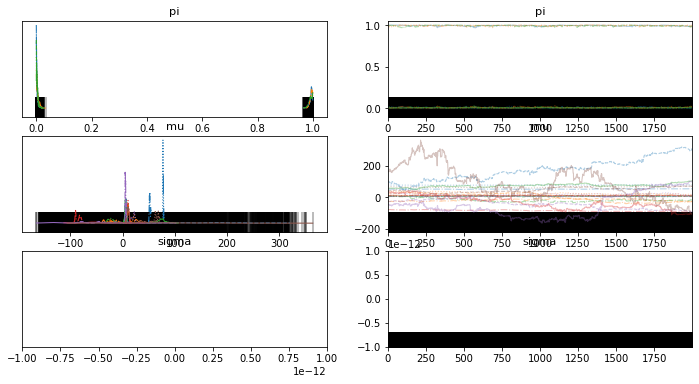

In [14]:
# stanのバージョンにより精度の違いはあるが、
# 基本的にRhatが悪化(>1.1)したりnanだったり、sigma のsdがinfなど結果がおかしいことを確認してください。 

# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit1)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary1 = arviz.summary(fit1)
summary1

In [12]:
model2 = stan.build(stan_code2, data=stan_data, random_seed=1)
# MCMCの実行
fit2 = model2.sample(
    num_warmup = 1000, # バーンイン期間
    num_chains = 4, #チェーン数
    num_samples= 2000, # 乱数生成の繰り返し回数
    num_thin = 1, #間引き数
)

Building...



Building: 44.4s, done.Messages from stanc:
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   0% (2/12000)
Sampling:   1% (101/12000)
Sampling:   2% (201/12000)
Sampling:   3% (301/12000)
Sampling:   3% (401/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1401/12000)
Sampling:  13% (1501/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sampling:  18% (2200/12000)
Sampling:  20% (2400/12000)
Sampling:  21% (2501/12000)
Sampling:  22% (2601/12000)
Sampling:  22% (2700/12000)
Sampling:  23% (2800/12000)
Sampling:  24% (2900/12000)
Sampling:  25% (3000/12000)
Sampling:  26% (3100/12000)
Sampling:  27% (3200/12000)
Sampling:  28% (3300/12000)
Samp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi[0],0.276,0.064,0.173,0.395,0.024,0.018,7.0,122.0,1.50
pi[1],0.394,0.107,0.189,0.531,0.048,0.037,7.0,27.0,1.53
pi[2],0.330,0.092,0.184,0.501,0.040,0.030,6.0,30.0,1.90
"mu[0, 0]",9.322,21.949,-15.584,33.965,10.909,8.350,6.0,125.0,1.73
"mu[0, 1]",-13.181,7.384,-23.596,-0.818,3.347,2.591,6.0,110.0,1.73
"mu[1, 0]",12.300,11.067,2.784,32.789,5.461,4.187,7.0,29.0,1.53
"mu[1, 1]",23.028,24.860,-22.103,41.658,12.353,9.455,7.0,27.0,1.53
"mu[2, 0]",3.028,18.065,-16.146,33.092,8.963,6.858,5.0,27.0,2.10
"mu[2, 1]",1.085,21.873,-22.406,40.374,10.805,8.262,5.0,27.0,2.40
"sigma[0, 0]",11.836,2.441,7.825,16.002,0.964,0.716,7.0,111.0,1.54


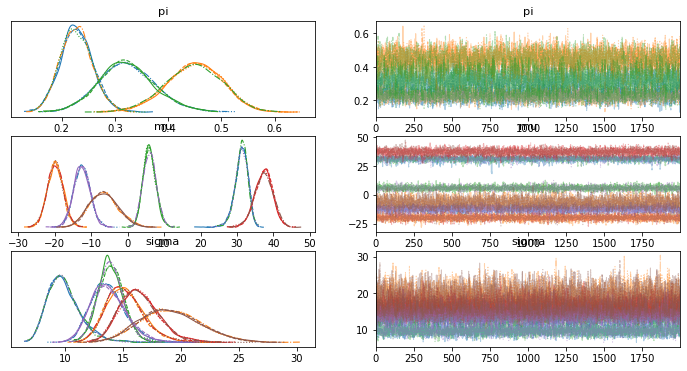

In [13]:
# Rhat はいまいちですが、sigma はずいぶん安定しました。

# MCMCの経過を簡易表示, muとsigmaのiter変化が見られる
arviz.plot_trace(fit2)

#  Gelman-Rubin 統計量 (r_hat)、Highest density interval (HDI) などの簡易表示
summary2 = arviz.summary(fit2)
summary2